In [1]:
import numpy as np
import cv2
import os
from scipy.spatial import distance
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from joblib import Parallel, delayed
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump, load
from sklearn.svm import SVC

In [2]:
def preprocess_image(image, contrast_factor: float = 2.0, sharpness_factor: float = 2.0):
    pil_image = Image.fromarray(image)
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(pil_image)
    image_enhanced = enhancer.enhance(contrast_factor) 

    # Enhance sharpness
    sharpener = ImageEnhance.Sharpness(image_enhanced)
    image_sharpened = sharpener.enhance(sharpness_factor) 

    # Convert to grayscale
    image_gray = image_sharpened.convert("L")

    # Convert back to numpy array
    return np.array(image_gray)

#per singoli caratteri
def load_image(folder, augment=True):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = os.path.join(folder, filename)
        for cat_filename in os.listdir(path):
            cat_path = os.path.join(path, cat_filename)
            img = cv2.imread(cat_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                #img = preprocess_image(img)
                category.append(img)
                if augment:
                    augmented_images = apply_augmentation(img)
                    category.extend(augmented_images)
        images[filename] = category
    return images

def apply_augmentation(img):
    augmented_images = []

    for _ in range(3):  
        transformed_img = img.copy()
        
        
        # Flip
        if random.random() > 0.5:
            transformed_img = cv2.flip(transformed_img, 1)
        
        augmented_images.append(transformed_img)
    
    return augmented_images


#feature exctraction with sift
def extract_features(images):
    sift = cv2.SIFT_create()
    features = {}
    for category, imgs in images.items():
        category_features = []
        for img in imgs:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                category_features.append(descriptors)
        if category_features:
            features[category] = np.vstack(category_features)
    return features

#creation of words vocabulary
def create_vocabulary(features, num_clusters=25):
    all_descriptors = np.vstack([descriptors for descriptors in features.values()])
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


def quantize_features(kmeans, images):
    histograms = {}
    sift = cv2.SIFT_create()
    for category, imgs in images.items():
        histograms[category] = []
        for img in imgs:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                histogram = np.zeros(kmeans.n_clusters)
                clusters = kmeans.predict(descriptors)
                for cluster in clusters:
                    histogram[cluster] += 1
                histograms[category].append(histogram)
    return histograms

def split_data(images, test_size=0.2):
    train_images = {}
    test_images = {}
    for category, imgs in images.items():
        train, test = train_test_split(imgs, test_size=test_size, random_state=42)
        train_images[category] = train
        test_images[category] = test
    return train_images, test_images



def knn(train_histograms, test_histograms, distance_metric='cosine'):
    def compute_distance(hist1, hist2, metric):
        return cosine(hist1, hist2)
    
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    total_tests = sum(len(histograms) for histograms in test_histograms.values())
    
    with tqdm(total=total_tests, desc="Processing tests") as pbar:
        for test_key, test_hist_list in test_histograms.items():
            class_based[test_key] = [0, 0]  # [correct, all]
            for tst in test_hist_list:
                minimum = float('inf')
                key = None  # predicted
                
                for train_key, train_hist_list in train_histograms.items():
                    for train_hist in train_hist_list:
                        dist = compute_distance(tst, train_hist, distance_metric)
                        if dist < minimum:
                            minimum = dist
                            key = train_key
                
                if test_key == key:
                    correct_predict += 1
                    class_based[test_key][0] += 1
                num_test += 1
                class_based[test_key][1] += 1
                pbar.update(1) 
                
    return [num_test, correct_predict, class_based]

def evaluate_results(results):
    num_test, correct_predict, class_based = results
    
    accuracy = correct_predict / num_test

    precision = {}
    recall = {}
    f1_score = {}
    for class_name, (correct, total) in class_based.items():
        precision[class_name] = correct / total if total > 0 else 0
        recall[class_name] = correct / len(test_histograms[class_name])
        f1_score[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name]) if (precision[class_name] + recall[class_name]) > 0 else 0

    return accuracy, precision, recall, f1_score

In [3]:
def visualize_clusters(kmeans, features, num_clusters=25):
    all_descriptors = np.vstack([descriptors for descriptors in features.values()])
    sample_indices = np.random.choice(all_descriptors.shape[0], size=1000, replace=False)
    sample_descriptors = all_descriptors[sample_indices]
    
    cluster_labels = kmeans.predict(sample_descriptors)
    
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    reduced_descriptors = tsne.fit_transform(sample_descriptors)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_descriptors[:, 0], reduced_descriptors[:, 1], c=cluster_labels, cmap='tab20', s=5)
    plt.colorbar(scatter, ticks=range(num_clusters))
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


#visualize image predictions in classes
def visualize_predictions(test_images, test_histograms, predicted_classes, num_examples_per_category=5):
    num_categories = len(test_images)
    examples_per_row = num_examples_per_category
    num_rows = num_categories

    fig, axes = plt.subplots(num_rows, examples_per_row, figsize=(15, 3*num_rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (category, imgs) in enumerate(test_images.items()):
        for j in range(num_examples_per_category):
            img_index = random.randint(0, len(imgs) - 1)
            img = imgs[img_index]

            if len(img.shape) == 2 or img.shape[2] == 1:  # Immagine in scala di grigi
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img_rgb)
            
            if category in predicted_classes:
                predicted_class_list = predicted_classes[category]
                if img_index < len(predicted_class_list):
                    predicted_class = predicted_class_list[img_index]
                    axes[i, j].set_title(f"Predicted: {predicted_class}, Actual: {category}")
                else:
                    axes[i, j].set_title(f"No prediction available, Actual: {category}")
            else:
                axes[i, j].set_title(f"No prediction available, Actual: {category}")
                
            axes[i, j].axis('off')

    for i in range(num_categories):
        for j in range(num_examples_per_category, examples_per_row):
            axes[i, j].remove()

    plt.show()


#to predicted classes of each image
def predict_classes(kmeans, train_histograms, test_histograms):
    predicted_classes = {}
    for test_key, test_hist_list in test_histograms.items():
        predicted_classes[test_key] = []
        for test_hist in test_hist_list:
            min_distance = float('inf')
            predicted_class = None
            for train_key, train_hist_list in train_histograms.items():
                for train_hist in train_hist_list:
                    dist = cosine(test_hist, train_hist)  
                    if dist < min_distance:
                        min_distance = dist
                        predicted_class = train_key
            predicted_classes[test_key].append(predicted_class)
    return predicted_classes

<H1>PER LETTERE</H1>

In [4]:
num_clusters=25
images = load_image('dataset2')

train_images, test_images = split_data(images, test_size=0.2)

train_features = extract_features(train_images)
test_features = extract_features(test_images)

<H2>KMEANS</H2>

In [ ]:
kmeans = create_vocabulary(train_features, num_clusters)

train_histograms = quantize_features(kmeans, train_images)

test_histograms = quantize_features(kmeans, test_images)
results_bowl = knn(train_histograms, test_histograms, distance_metric='cosine')

In [ ]:
with open('BoVW/kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('BoVW/train_histograms.pkl', 'wb') as file:
    pickle.dump(train_histograms, file)

with open('BoVW/test_histograms.pkl', 'wb') as file:
    pickle.dump(test_histograms, file)

with open('BoVW/results_bowl.pkl', 'wb') as file:
    pickle.dump(results_bowl, file)


In [6]:

with open('BoVW/kmeans_model.pkl', 'rb') as file:
    kmeans = pickle.load(file)

with open('BoVW/train_histograms.pkl', 'rb') as file:
    train_histograms = pickle.load(file)

with open('BoVW/test_histograms.pkl', 'rb') as file:
    test_histograms = pickle.load(file)

with open('BoVW/results_bowl.pkl', 'rb') as file:
    results_bowl = pickle.load(file)


accuracy, precision, recall, f1_score = evaluate_results(results_bowl)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("recall: ", recall)
print("f1_score: ", f1_score)

Accuracy:  0.8261175147596289
Precision:  {'a': 0.8549019607843137, 'b': 0.8255813953488372, 'c': 0.8346774193548387, 'd': 0.8455056179775281, 'e': 0.8054474708171206, 'f': 0.7954545454545454, 'g': 0.8174603174603174, 'h': 0.8343949044585988, 'i': 0.920388349514563, 'k': 0.8421052631578947, 'l': 0.7100737100737101, 'm': 0.8396946564885496, 'n': 0.8276699029126213, 'o': 0.8820598006644518, 'p': 0.8552631578947368, 'q': 0.6666666666666666, 'r': 0.8044077134986226, 's': 0.8171557562076749, 't': 0.8494623655913979, 'u': 0.7409638554216867, 'v': 0.7819148936170213, 'w': 0.7760416666666666, 'x': 0.875, 'y': 0.8511904761904762, 'z': 0.7}
recall:  {'a': 0.8549019607843137, 'b': 0.8255813953488372, 'c': 0.8346774193548387, 'd': 0.8455056179775281, 'e': 0.8054474708171206, 'f': 0.7954545454545454, 'g': 0.8174603174603174, 'h': 0.8343949044585988, 'i': 0.920388349514563, 'k': 0.8421052631578947, 'l': 0.7100737100737101, 'm': 0.8396946564885496, 'n': 0.8276699029126213, 'o': 0.8820598006644518, 'p

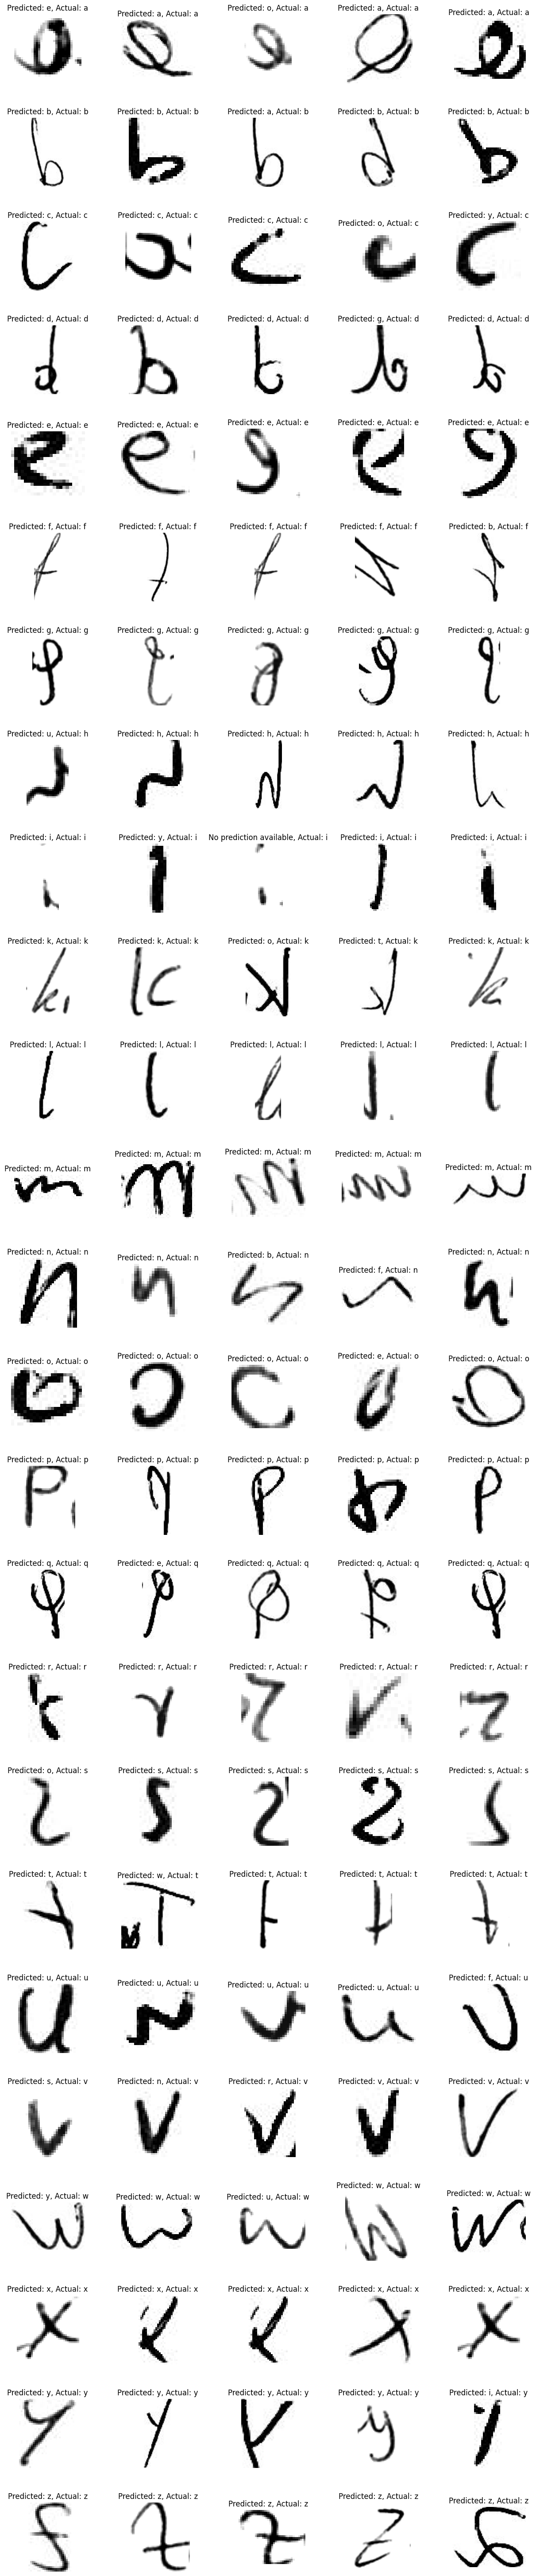

In [92]:
predicted_classes = predict_classes(kmeans, train_histograms, test_histograms)

visualize_predictions(test_images, test_histograms, predicted_classes, num_examples_per_category=5)


visualize_clusters(kmeans, test_features, num_clusters=num_clusters)

<H2>RANDOM FOREST</H2>

In [86]:
X_train = []
y_train = []
for category, histograms in train_histograms.items():
    for hist in histograms:
        X_train.append(hist)
        y_train.append(category)

X_test = []
y_test = []
for category, histograms in test_histograms.items():
    for hist in histograms:
        X_test.append(hist)
        y_test.append(category)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           a       0.83      0.86      0.85       510
           b       0.95      0.81      0.88       172
           c       0.83      0.82      0.82       248
           d       0.82      0.85      0.83       356
           e       0.81      0.84      0.82       514
           f       0.88      0.78      0.83       176
           g       0.92      0.78      0.84       252
           h       0.80      0.83      0.82       314
           i       0.81      0.90      0.86       515
           k       0.95      0.76      0.85        76
           l       0.82      0.78      0.80       407
           m       0.86      0.88      0.87       262
           n       0.80      0.83      0.82       412
           o       0.84      0.93      0.88       602
           p       0.88      0.83      0.85       152
           q       0.84      0.67      0.74        24
           r       0.82      0.79      0.81

In [91]:
image_path = r"dataset2\a\a_0001-4-2-3-animals_character_1.png"
pil_image = Image.open(image_path)

enhancer = ImageEnhance.Contrast(pil_image)
image_enhanced = enhancer.enhance(2.0)
sharpener = ImageEnhance.Sharpness(image_enhanced)
image_sharpened = sharpener.enhance(2.0)

image_cv = np.array(image_sharpened)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(image_cv, None)

if descriptors is not None:
    histogram = np.zeros(kmeans.n_clusters)
    clusters = kmeans.predict(descriptors)
    for cluster in clusters:
        histogram[cluster] += 1
    
    predicted_class = clf.predict([histogram])[0]
    print("Predicted class:", predicted_class)
else:
    print("No features found in the image.")


Predicted class: a
